# Image Captioning Computer Vision.

Name: Anthony Kevin Oktavius

Paper and Dataset can be found at this link: https://paperswithcode.com/dataset/flickrstyle10k

Library Import

In [2]:
import numpy as np
import zipfile
import gc
import pickle
import cv2
import math
import warnings
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
# import torchmetrics
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils

# import pytorch_lightning as pl
import imutils
import zipfile

from PIL import Image
from torch.utils.data import Dataset
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, roc_curve
# from pytorch_lightning.loggers import TensorBoardLogger

Import pretrained models that we'd like to import, and to compare.

In [3]:
from torchvision.models import resnet50, ResNet50_Weights, \
  densenet161, DenseNet161_Weights, \
  shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights, \
  googlenet, GoogLeNet_Weights

## Data Preparation

Download and Unzip the Dataset

In [5]:
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! kaggle datasets download -d adityajn105/flickr8k
! unzip -qq ./flickr8k.zip -d ./Dataset

100% 1.03G/1.04G [00:34<00:00, 18.1MB/s]
100% 1.04G/1.04G [00:34<00:00, 32.0MB/s]


## Data Preprocessing

Prepare ImageFolder

In [6]:
train_transform = transforms.Compose([
    transforms.CenterCrop((320, 320)),
    transforms.Resize((128, 128)), # Mitigate if there's a "RAM is not enough" error.
    transforms.RandomRotation(degrees = 5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
    # ),
])

val_transform = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    transforms.Resize((128, 128)), # Mitigate if there's a "RAM is not enough" error.
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
    # ),
])

In [7]:
captions_iterator = open("Dataset/captions.txt", 'r')

image_name_to_labels_dict = defaultdict(list)
image_paths = defaultdict()
MAX_SENTENCE_LENGTH = 0

for text_per_line in captions_iterator.readlines()[1:]:
  image_name, label = text_per_line.split(".jpg,")
  image_name = f"{image_name}.jpg"
  label = label.strip("\n")
  label = f"<START> {label}"
  label = label.replace(".", "<END>")
  words_in_a_label = label.split(" ")

  if len(words_in_a_label) > MAX_SENTENCE_LENGTH:
    print(words_in_a_label)
    MAX_SENTENCE_LENGTH = len(words_in_a_label)

  image_name_to_labels_dict[image_name].append(label)

print("Example image_name to label dict: ")
print(image_name_to_labels_dict["1000268201_693b08cb0e.jpg"])
captions_iterator.close()
print(f"Max length for the dataset given: {MAX_SENTENCE_LENGTH}")

['<START>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<END>']
['<START>', 'A', 'black', 'dog', 'and', 'a', 'white', 'dog', 'with', 'brown', 'spots', 'are', 'staring', 'at', 'each', 'other', 'in', 'the', 'street', '<END>']
['<START>', 'A', 'little', 'girl', 'covered', 'in', 'paint', 'sits', 'in', 'front', 'of', 'a', 'painted', 'rainbow', 'with', 'her', 'hands', 'in', 'a', 'bowl', '<END>']
['<START>', 'A', 'small', 'girl', 'in', 'the', 'grass', 'plays', 'with', 'fingerpaints', 'in', 'front', 'of', 'a', 'white', 'canvas', 'with', 'a', 'rainbow', 'on', 'it', '<END>']
['<START>', '"A', 'couple', 'and', 'an', 'infant', ',', 'being', 'held', 'by', 'the', 'male', ',', 'sitting', 'next', 'to', 'a', 'pond', 'with', 'a', 'near', 'by', 'stroller', '<END>"']
['<START>', 'A', 'man', 'is', 'holding', 'the', 'hand', 'of', 'a', 'woman', 'up', 'to', 'his', 'mouth', 'in', 'front', 'of', 'some', 'buildings', 'while', 'another

Gather all image names, then train test split 80% and 20%.

In [8]:
image_paths = os.listdir("/content/Dataset/Images/")
TOTAL_AMOUNT_OF_DATA = len(image_paths)

NUMBER_OF_TRAIN_DATA = int(0.8 * TOTAL_AMOUNT_OF_DATA)
NUMBER_OF_VAL_DATA = TOTAL_AMOUNT_OF_DATA - NUMBER_OF_TRAIN_DATA

# Get the train and val images.
train_image_names = image_paths[:NUMBER_OF_TRAIN_DATA]
val_image_names = image_paths[NUMBER_OF_TRAIN_DATA:NUMBER_OF_TRAIN_DATA+NUMBER_OF_VAL_DATA]

print(train_image_names[:10])
print(val_image_names[:10])

['812196663_0c969970b5.jpg', '2181846120_3744ca3942.jpg', '2760716468_b541e9fd0f.jpg', '3016521240_2ef20834b6.jpg', '1237985362_dbafc59280.jpg', '2534194182_ac53035cf4.jpg', '3353036763_4cbeba03b2.jpg', '3244586044_205d5ae2ba.jpg', '3296715418_29542dcdc2.jpg', '3687222696_85bf6f78f7.jpg']
['121971540_0a986ee176.jpg', '3584534971_b44f82c4b9.jpg', '239453674_0df7767208.jpg', '334737767_7f344eee16.jpg', '3111897772_5211a37a02.jpg', '837919879_94e3dacd83.jpg', '3319899418_4bcf1b00d8.jpg', '2873070704_2141a7a86a.jpg', '3276475986_66cd9cc7e4.jpg', '3607969989_68cc411493.jpg']


## Data Preparation

In [9]:
NUMBER_OF_LABELS_PER_SAMPLE = 5
DATASET_BASE_PATH = "/content/Dataset/Images"

class FlickrStyleDataset(Dataset):
  def __init__(self, base_path, image_names, image_name_to_labels_dict, image_transform, number_of_labels_per_sample):
    super(FlickrStyleDataset, self).__init__()
    self.base_path = base_path
    self.image_names = image_names
    self.image_name_to_labels_dict = image_name_to_labels_dict
    self.image_transform = image_transform
    self.number_of_labels_per_sample = number_of_labels_per_sample

  def __getitem__(self, image_index):
    image_name = self.image_names[image_index]
    image_path = f"{self.base_path}/{image_name}"
    image = Image.open(image_path)

    if self.image_transform:
      image = self.image_transform(image)

    label = self.image_name_to_labels_dict[image_name]

    return image, label

  def __len__(self):
    return len(self.image_names)

flickr_train_dataset = FlickrStyleDataset(
    DATASET_BASE_PATH,
    train_image_names,
    image_name_to_labels_dict,
    train_transform,
    NUMBER_OF_LABELS_PER_SAMPLE
)

flickr_val_dataset = FlickrStyleDataset(
    DATASET_BASE_PATH,
    val_image_names,
    image_name_to_labels_dict,
    train_transform,
    NUMBER_OF_LABELS_PER_SAMPLE
)

print(flickr_train_dataset[0][0].shape)
print(flickr_val_dataset[0][1])

torch.Size([3, 128, 128])
['<START> two men cleaning the outside windows of a yacht', '<START> Two men climb the side of a boat <END>', '<START> Two men on the side of a barge', '<START> Two people outside cleaning windows while on a ledge of a boat <END>', '<START> Two people stand on the side of a large white and red boat <END>']


Generate a dataset loader.

In [10]:
flickr_train_dataloader = torch.utils.data.DataLoader(
    flickr_train_dataset,
    batch_size = 4,
    shuffle = True,
)

flickr_val_dataloader = torch.utils.data.DataLoader(
    flickr_val_dataset,
    batch_size = 4,
    shuffle = True,
)

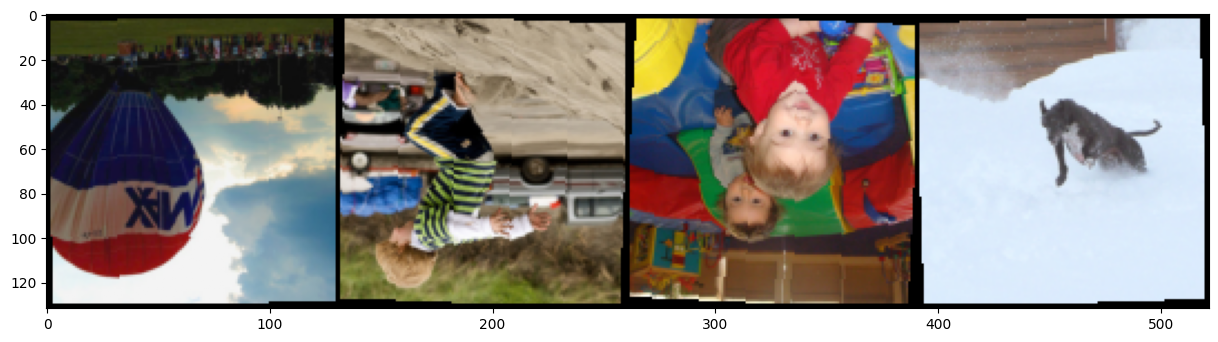

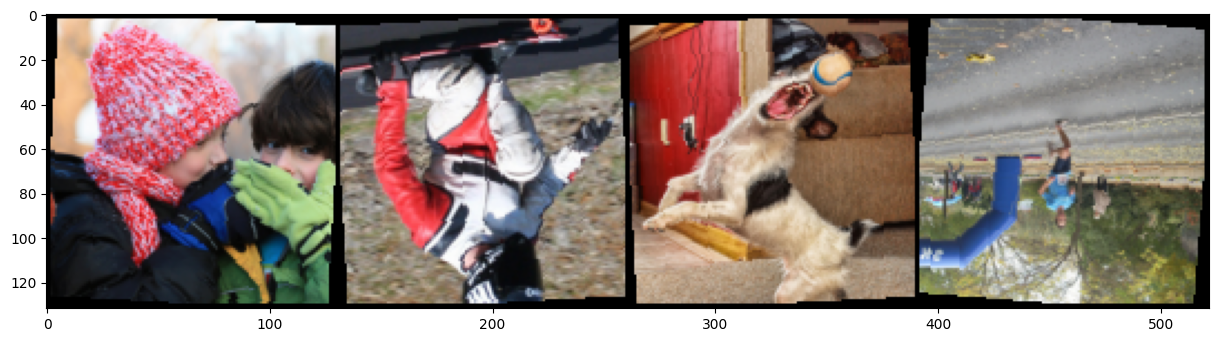

In [11]:
def plot_images_in_grid(title, images, labels, figsize = (15, 15), MIN_INDEX_PLOT = 0, MAX_INDEX_PLOT = 20):
  plt.figure(figsize = figsize)
  plt.suptitle(title)
  for index in range(MIN_INDEX_PLOT, MAX_INDEX_PLOT):
    plt.subplot(5, 5, index + 1)
    plt.axis('off')
    plt.text(x = 10, y = 0.5, s = labels[index], fontsize = 10, bbox = dict(facecolor = 'white'))
    plt.imshow(images[index], cmap = 'gray')

def visualize_pytorch_grid(images_in_batch):
  plt.figure(figsize = (15, 15))
  grid_images_in_batch = torchvision.utils.make_grid(images_in_batch)
  plt_compatible_grid_images_in_batch = np.transpose(grid_images_in_batch.numpy(), (1, 2, 0))
  plt.imshow(plt_compatible_grid_images_in_batch)

def visualize_dataloader(data_loader, title):
  iter_loader = iter(data_loader)
  input_image_in_batch, _ = next(iter_loader)

  visualize_pytorch_grid(input_image_in_batch)

visualize_dataloader(flickr_train_dataloader, "Train Transformed Image")
visualize_dataloader(flickr_val_dataloader, "Validation Transformed Image")

## Data Modelling

The model is quite similar to what I've done in video classification, since CNN extracts important feature information from the image.

In [23]:
from torchvision.models import resnet50, ResNet50_Weights, \
  densenet161, DenseNet161_Weights, \
  shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights, \
  googlenet, GoogLeNet_Weights

class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    self.pretrained_model = None
    # Get all the model layers, except Sequential Layers,
    # since we'd like to iterate the layers one by one.
    self.flatten_layers_exception = [torch.nn.modules.container.Sequential]
    self.max_layer_index = None

  def __flatten_layers_from_model__(self):
    model_layers = list(self.pretrained_model.modules())[1:]
    flattened_model_layers = []

    for index, layer in enumerate(model_layers):
      # print(type(layer))
      if type(layer) not in self.flatten_layers_exception:
        flattened_model_layers.append(layer)

      if index is not None and index == self.max_layer_index:
        break

    return flattened_model_layers

  def forward(self, x):
    for layer in self.__flatten_layers_from_model__():
      x = layer(x)
    return x

  def print_model_layers(self):
    print("==========================================================")
    print("Layer Names:")
    layers = self.__flatten_layers_from_model__()
    for index, layer in enumerate(layers):
      print(f"{index}: {layer}")
    print("==========================================================")

  def print_model_architecture(self):
    print(self.pretrained_model)

class ResNetFeatureExtractor(FeatureExtractor):
  def __init__(self):
    super(ResNetFeatureExtractor, self).__init__()
    self.pretrained_model = resnet50(
        weights = ResNet50_Weights,

    )
    self.max_layer_index = 141


class DenseNetFeatureExtractor(FeatureExtractor):
  def __init__(self):
    super(DenseNetFeatureExtractor, self).__init__()
    self.pretrained_model = densenet161(weights = DenseNet161_Weights)
    self.max_layer_index = 569

class ShuffleNetFeatureExtractor(FeatureExtractor):
  def __init__(self):
    super(ShuffleNetFeatureExtractor, self).__init__()
    self.pretrained_model = shufflenet_v2_x1_0(weights = ShuffleNet_V2_X1_0_Weights)
    self.max_layer_index = 165

class GoogleNetFeatureExtractor(FeatureExtractor):
  def __init__(self):
    super(GoogleNetFeatureExtractor, self).__init__()
    self.pretrained_model = googlenet(weights = GoogLeNet_Weights)
    self.max_layer_index = 194

resnet_feature_extractor = ResNetFeatureExtractor()
densenet_feature_extractor = DenseNetFeatureExtractor()
shufflenet_feature_extractor = ShuffleNetFeatureExtractor()
googlenet_feature_extractor = GoogleNetFeatureExtractor()

resnet_feature_extractor.eval()
densenet_feature_extractor.eval()
shufflenet_feature_extractor.eval()
googlenet_feature_extractor.eval()

resnet_feature_extractor.print_model_layers()
densenet_feature_extractor.print_model_layers()
shufflenet_feature_extractor.print_model_layers()
googlenet_feature_extractor.print_model_layers()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be remov

Layer Names:
0: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2: ReLU(inplace=True)
3: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4: Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [49]:
class Seq2SeqEncoder(nn.Module):
  def __init__(self, image_feature_extractor_model, desired_number_of_image_features):
    super(Seq2SeqEncoder, self).__init__()
    self.image_feature_extractor_model = image_feature_extractor_model

  def forward(self, x):
    self.image_feature_extractor_model.eval()
    x = self.image_feature_extractor_model(x)
    print(f"Feature size: {x.shape}")
    x = self.dense_1(x)
    return x

NUMBER_OF_DESIRED_IMAGE_FEATURES = 10000

seq2seq_encoder = Seq2SeqEncoder(
    image_feature_extractor_model = resnet_feature_extractor,
    desired_number_of_image_features = NUMBER_OF_DESIRED_IMAGE_FEATURES,
)
print(seq2seq_encoder)

Seq2SeqEncoder(
  (image_feature_extractor_model): ResNetFeatureExtractor(
    (pretrained_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

In [48]:
class Seq2SeqDecoder(nn.Module):
  def __init__(self, number_of_image_features, max_words_in_label):
    super(Seq2SeqDecoder, self).__init__()
    self.max_words_in_label = max_words_in_label
    self.number_of_image_features = number_of_image_features
    NUM_LAYERS = 1 # We just only use 1 LSTM, but not stacking them.
    HIDDEN_SIZE = 64
    self.lstm_1 = nn.LSTM(self.number_of_image_features, HIDDEN_SIZE, NUM_LAYERS)
    for word_index in range(self.max_words_in_label):
      lstm = nn.LSTM(
          self.number_of_image_features, HIDDEN_SIZE, NUM_LAYERS
      )
      setattr(Seq2SeqDecoder, f'lstm_{word_index+2}', lstm)

  def forward(self, x):
    x, h1 = self.lstm_1(x)
    for lstm_index in range(self.max_words_in_label):
      lstm = getattr(self, f"lstm_{lstm_index+2}")
      break
    pass

seq2seq_decoder = Seq2SeqDecoder(
    number_of_image_features = NUMBER_OF_DESIRED_IMAGE_FEATURES,
    max_words_in_label = MAX_SENTENCE_LENGTH - 1
)
print(seq2seq_decoder)

Seq2SeqDecoder(
  (lstm_1): LSTM(10000, 64)
)


In [44]:
class Seq2SeqImageCaptioningModel(nn.Module):
  def __init__(self, encoder, decoder, desired_number_of_image_features):
    super(Seq2SeqImageCaptioningModel, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.dense_1 = nn.Linear(
        5000, desired_number_of_image_features
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.dense_1(x)
    x = self.decoder(x)
    return x

seq_2_seq_image_captioning_model = Seq2SeqImageCaptioningModel(
  encoder = seq2seq_encoder,
  decoder = seq2seq_decoder,
  desired_number_of_image_features = NUMBER_OF_DESIRED_IMAGE_FEATURES
)
print(seq_2_seq_image_captioning_model)

Seq2SeqImageCaptioningModel(
  (encoder): Seq2SeqEncoder(
    (image_feature_extractor_model): ResNetFeatureExtractor(
      (pretrained_model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

Model Training